In [490]:
import ROOT
import uproot
import matplotlib.pyplot as plt
import scipy as scp
from scipy.integrate import trapezoid
import numpy as np
import awkward as ak
import pybaselines
from sklearn.preprocessing import normalize as norm

In [491]:
FILE_PATH = "../Dati/Run_chall_ortho_Data_5_10_2024_Ascii_0001_newcut.root" #Relative file path
file1 = uproot.open(FILE_PATH)
file1["tree"].show()

FILE_PATH_2 = "../Dati/Run_chall_ortho_Data_5_10_2024_Ascii_0002_newcut.root" #Relative file path
file2 = uproot.open(FILE_PATH_2)

FILE_PATH_3 = "../Dati/Run_chall_ortho_Data_5_10_2024_Ascii_0003_newcut.root" #Relative file path
file3 = uproot.open(FILE_PATH_3)

FILE_PATH_4 = "../Dati/Run_chall_ortho_Data_5_10_2024_Ascii_0004_newcut.root" #Relative file path
file4 = uproot.open(FILE_PATH_4)

FILE_PATH_5 = "../Dati/Run_chall_ortho_Data_5_10_2024_Ascii_0005.root" #Relative file path
file5 = uproot.open(FILE_PATH_5)

FILE_PATH_6 = "../Dati/Run_Na_ortho_468ps_trig_on_1200keV_Data_5_27_2024_Ascii_0000.root"
file6=uproot.open(FILE_PATH_6)

FILE_PATH_7 = "../Dati/Ortopositronio/Run_ortho2_468ps_Data_5_31_2024_Ascii_0000.root"
file7=uproot.open(FILE_PATH_7)

FILE_PATH_8 = "../Dati/Run_ortho2_468ps_Data_5_31_2024_Ascii_0001.root"
file8=uproot.open(FILE_PATH_8)

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
ev                   | int32_t                  | AsDtype('>i4')
nch                  | int32_t                  | AsDtype('>i4')
ch                   | int32_t[]                | AsJagged(AsDtype('>i4'))
base                 | float[]                  | AsJagged(AsDtype('>f4'))
amp                  | float[]                  | AsJagged(AsDtype('>f4'))
charge               | float[]                  | AsJagged(AsDtype('>f4'))
letime               | float[]                  | AsJagged(AsDtype('>f4'))
tetime               | float[]                  | AsJagged(AsDtype('>f4'))
pshape               | float[][1024]            | AsJagged(AsDtype("('>f4', (...


In [492]:
print(type(file1["tree"]["base"].array()))
bl=file1["tree"]["base"].array()
print(ak.num(bl))
#bl = bl[:-1]
print(np.unique(ak.num(bl)))
#l'ultimo array aveva una forma diversa, quindi l'ho tagliato altrimenti faceva casini

nch=file1["tree"]["ch"].array()
print(nch)

<class 'awkward.highlevel.Array'>
[16, 16, 16, 16, 16, 16, 16, 16, 16, ..., 16, 16, 16, 16, 16, 16, 16, 16, 16]
[16]
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], ..., [0, 1, ..., 15]]


In [493]:
def extract_data(file):
    baselines = np.array(file["tree"]["base"])[1:-1]
    charges = np.array(file["tree"]["charge"])[1:-1]
    amp = np.array(file["tree"]["amp"])[1:-1]
    lead_edge = np.array(file["tree"]["letime"])[1:-1]
    t_edge = np.array(file["tree"]["tetime"])[1:-1]
    channel = np.array(file["tree"]["ch"])[1:-1]
    waveform = np.array(file["tree"]["pshape"])[1:-1]
    
    return baselines, charges, amp, lead_edge, t_edge, channel, waveform

# Use the function for each batch
baselines1, charges1, amp1, lead_edge1, t_edge1, channel1, waveform1 = extract_data(file1)
baselines2, charges2, amp2, lead_edge2, t_edge2, channel2, waveform2 = extract_data(file2)
baselines3, charges3, amp3, lead_edge3, t_edge3, channel3, waveform3 = extract_data(file3)
baselines4, charges4, amp4, lead_edge4, t_edge4, channel4, waveform4 = extract_data(file4)
baselines5, charges5, amp5, lead_edge5, t_edge5, channel5, waveform5 = extract_data(file5)
baselines6, charges6, amp6, lead_edge6, t_edge6, channel6, waveform6 = extract_data(file6)
baselines7, charges7, amp7, lead_edge7, t_edge7, channel7, waveform7 = extract_data(file7)
baselines8, charges8, amp8, lead_edge8, t_edge8, channel8, waveform8 = extract_data(file8)

#concatenate arrays

baselines=np.concatenate((baselines1, baselines2, baselines3, baselines4, baselines5, baselines6, baselines7, baselines8))
charges = np.concatenate((charges1, charges2, charges3,charges4, charges5, charges6, charges7, charges8))
amp = np.concatenate((amp1, amp2, amp3, amp4, amp5, amp6, amp7, amp8))
lead_edge = np.concatenate((lead_edge1, lead_edge2, lead_edge3,lead_edge4, lead_edge5, lead_edge6, lead_edge7, lead_edge8))
t_edge = np.concatenate((t_edge1, t_edge2, t_edge3,t_edge4, t_edge5, t_edge6, t_edge7, t_edge8))
channel = np.concatenate((channel1, channel2, channel3,channel4, channel5, channel6, channel7, channel8))
waveform = np.concatenate((waveform1,waveform2, waveform3,waveform4, waveform5, waveform6, waveform7, waveform8))



In [494]:
#carico la matrice degli offset
def load_matrix(filename):
    return(np.load(filename))

loaded=load_matrix('offset_matrix.npz')
matrix_loaded = loaded['arr_0']
print(matrix_loaded)

[[ 0.          1.97790006  8.30515642  5.13880779  3.25188705  0.60127363
   4.63887604  2.23860842  2.96122492  1.7662929   0.08214686  2.61439973
   5.75674346  0.          2.66775925  2.25991482]
 [-1.97790006  0.          6.65268982  3.35018406  1.62865816 -1.42310493
   3.35363686 -0.09357444  1.55745866 -0.03231273 -2.23996373  0.60939011
   4.72326522  0.          2.19416517  0.31886456]
 [-8.30515642 -6.65268982  0.         -3.16529453 -4.96229802 -7.97382458
  -3.7849691  -6.49220942 -5.17749042 -6.89120561 -8.45633986 -5.88758847
  -2.87454218 -1.5810066  -4.69470296 -6.61630156]
 [-5.13880779 -3.35018406  3.16529453  0.         -1.74554839 -4.80185979
  -0.55825317 -3.03106198 -1.99820973 -3.57586387 -4.96672159 -2.73908285
   0.62833715  0.         -1.49089966 -3.16862866]
 [-3.25188705 -1.62865816  4.96229802  1.74554839  0.         -3.28007198
   1.04874026 -1.23946888 -0.16332661 -2.06401735 -3.11165703 -1.13443192
   2.46599326  0.         -0.9021026  -1.78743256]
 [-0.

In [495]:
print(amp.shape)
print(charges.shape)
print(len(amp))

(24476,)
(24476,)
24476


In [496]:
len(np.where(amp[0]>-1.2)[0])==16

True

In [497]:
print(channel)

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       dtype=int32)
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       dtype=int32)
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       dtype=int32)
 ... array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15],
           dtype=int32)
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15],
       dtype=int32)
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15],
       dtype=int32)                                                 ]


In [498]:

mask=[len(np.where(amp[i]>-1.2)[0])==16 for i in range(len(amp))]
print(mask)
baselines=baselines[mask]
charges=charges[mask]
amp=amp[mask]
lead_edge=lead_edge[mask]
t_edge=t_edge[mask]
channel=channel[mask]
waveform=waveform[mask]

[True, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, False, True, True, True, False, False, True, True, True, True, True, True, True, True, False, True, True, True, True, False, True, True, True, False, True, True, True, True, False, False, True, False, False, True, True, True, False, True, True, True, True, False, True, True, True, True, False, False, True, True, False, False, True, True, True, True, False, True, False, False, True, True, False, True, True, False, True, False, True, True, True, True, True, False, False, True, True, True, False, True, True, False, False, False, False, True, True, False, False, True, True, True, False, True, True, False, True, False, True, True, True, False, True, True, False, True, True, False, True, False, True, True, True, True, True, True, True, True, True, True, False, True, True, False, True, True, True, False, True, False, True, True, False, False, Tru

In [499]:
print(len(amp))
Nev=len(amp)

13121


(13121,)
channel: 0 baseline: 3.8e-05 charge -0.143 lead_edge 406.775 trailing_edge 405.41
channel: 1 baseline: 0.000191 charge 2.54 lead_edge 25.504 trailing_edge 23.099
channel: 2 baseline: 0.000267 charge 0.732 lead_edge 168.437 trailing_edge 164.538
channel: 3 baseline: -0.000229 charge 0.583 lead_edge 176.326 trailing_edge 172.149
channel: 4 baseline: 0.000305 charge -460.422 lead_edge 310.68 trailing_edge 73.311
channel: 5 baseline: 0.000229 charge -0.915 lead_edge 239.617 trailing_edge 235.19
channel: 6 baseline: 0.0 charge -2.276 lead_edge 336.543 trailing_edge 332.648
channel: 7 baseline: 0.0 charge -526.204 lead_edge 260.995 trailing_edge 0.001
channel: 8 baseline: 0.000114 charge 0.069 lead_edge 284.92 trailing_edge 283.268
channel: 9 baseline: -3.8e-05 charge -0.257 lead_edge 22.431 trailing_edge 21.773
channel: 10 baseline: -0.008464 charge 1.859 lead_edge 178.322 trailing_edge 176.286
channel: 11 baseline: 0.000267 charge -3.266 lead_edge 235.504 trailing_edge 233.059
cha

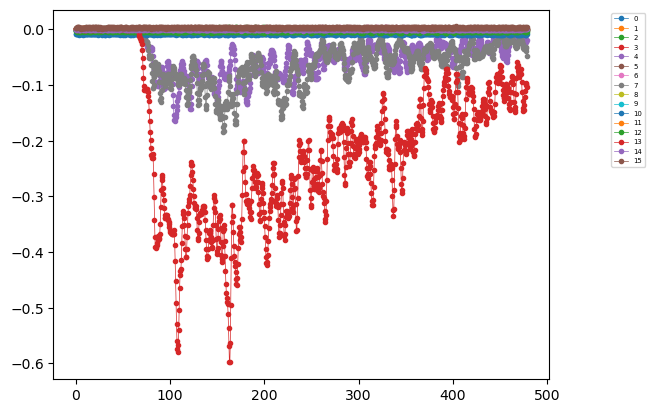

In [500]:
print(waveform.shape)
event=285
list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
#list=[1,2,7,12]
sampling=0.468
for channel in list:
    time=np.arange(1024)
    plt.plot(time*sampling, waveform[event][channel], '.-', label='{}'.format(channel), linewidth=0.5)
    print("channel:", channel, "baseline:",  baselines[event][channel],"charge", charges[event][channel], "lead_edge", lead_edge[event][channel], "trailing_edge", t_edge[event][channel] )
    t1=lead_edge[event][channel]
    t2=t_edge[event][channel]
    #print(t1,t2)
    #plt.scatter( t1, waveform[event][channel][int(t1/sampling)],s=60   )
    #plt.scatter( t2, waveform[event][channel][int(t2/sampling)],s=60  )
    #plt.xlim(400,600)
    #plt.ylim(-0.01, 0.1)

plt.legend(fontsize=5, loc='upper right', bbox_to_anchor=(1.2, 1))

In [501]:
###pulizia
list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
true_charges=[]
true_amps=[]
true_channels=[]
true_waveforms=[]
true_ledge=[]
for ev in range(Nev):
    interesting_channels=np.where(charges[ev]<-50)[0] #canali che hanno visto qualcosa
    true_channels.append(interesting_channels.tolist())
    true_charges.append([charges[ev][ch] for ch in interesting_channels])
    true_amps.append([amp[ev][ch] for ch in interesting_channels])
    true_waveforms.append([waveform[ev][ch] for ch in interesting_channels])
    true_ledge.append([lead_edge[ev][ch] for ch in interesting_channels])


#print(true_channels)
#print(true_charges)


#devo selezionare le annichilazioni back to back e isolarle dal resto


In [502]:
#eventi con 3 gamma
n_photons=[len(true_channels[i]) for i in range(Nev)]
n_photons=np.array(n_photons)
three_gamma_events=np.where(n_photons == 4)[0] #eventi con 4 fotoni totali (ortopositronio?)
print(three_gamma_events)
four_gamma_events=np.where(n_photons == 5)[0]
print(four_gamma_events)

[   30    44    58    75    77    85    93   106   107   108   111   116
   128   129   131   141   191   201   218   241   251   254   294   305
   309   344   358   362   368   369   372   378   381   385   393   402
   429   438   450   508   517   527   536   537   541   575   580   595
   597   606   633   641   642   668   674   678   681   699   759   760
   770   779   790   801   805   813   815   829   840   854   889   937
   940   979   993  1043  1128  1150  1169  1175  1206  1238  1249  1259
  1268  1277  1291  1314  1324  1355  1365  1369  1378  1389  1396  1399
  1413  1442  1454  1474  1477  1488  1499  1521  1534  1556  1570  1588
  1599  1603  1605  1625  1629  1633  1634  1641  1644  1653  1666  1723
  1735  1756  1758  1765  1806  1807  1818  1823  1829  1833  1834  1843
  1864  1901  1902  1906  1943  1963  1968  1972  1973  2000  2036  2049
  2080  2082  2090  2112  2134  2168  2176  2178  2205  2209  2210  2225
  2231  2245  2255  2285  2304  2310  2321  2327  2

In [503]:
#plot degli eventi di papabile ortopositronio

# Define the number of events to plot
"""num_events = len(three_gamma_events)

# Define the layout of subplots
num_cols = 2  # Number of columns of subplots
num_rows = (num_events + num_cols - 1) // num_cols  # Calculate the number of rows needed

# Create a new figure and axes for each subplot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 18))

# Flatten the axes array if it's multidimensional
axes = axes.flatten()

# Loop over each event in the event list
for i, event in enumerate(three_gamma_events):
    # Retrieve the list of channels for the current event
    list = true_channels[event]
    
    # Plot waveforms for each channel in the event
    for channel in list:
        time = np.arange(1024)  # Create an array of time samples
        axes[i].plot(time * sampling, waveform[event][channel], '.-', label='{}'.format(channel), linewidth=0.5)
        print("channel:", channel, "baseline:", baselines[event][channel], "charge", charges[event][channel], "lead_edge", lead_edge[event][channel], "trailing_edge", t_edge[event][channel])
        t1 = lead_edge[event][channel]
        t2 = t_edge[event][channel]
        #axes[i].scatter(t1, waveform[event][channel][int(t1 / sampling)], s=60)
        #axes[i].scatter(t2, waveform[event][channel][int(t2 / sampling)], s=60)
    
    # Add legend to the subplot
    axes[i].legend(fontsize=5, loc='upper right', bbox_to_anchor=(1.2, 1))
    axes[i].set_title(f'Event {event}')  # Set title for the subplot

# Adjust layout and display the plot
plt.tight_layout()
plt.show()"""



'num_events = len(three_gamma_events)\n\n# Define the layout of subplots\nnum_cols = 2  # Number of columns of subplots\nnum_rows = (num_events + num_cols - 1) // num_cols  # Calculate the number of rows needed\n\n# Create a new figure and axes for each subplot\nfig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 18))\n\n# Flatten the axes array if it\'s multidimensional\naxes = axes.flatten()\n\n# Loop over each event in the event list\nfor i, event in enumerate(three_gamma_events):\n    # Retrieve the list of channels for the current event\n    list = true_channels[event]\n    \n    # Plot waveforms for each channel in the event\n    for channel in list:\n        time = np.arange(1024)  # Create an array of time samples\n        axes[i].plot(time * sampling, waveform[event][channel], \'.-\', label=\'{}\'.format(channel), linewidth=0.5)\n        print("channel:", channel, "baseline:", baselines[event][channel], "charge", charges[event][channel], "lead_edge", lead_edge[event][cha

In [504]:
shift = 5

def times_from_waveforms(wf_narr, n_conv, threshold):

    lenghts = []
    wf_arr = []

    for evt in range(len(wf_narr)):
        for ch in range(len(wf_narr[evt])):
            wf_arr.append(wf_narr[evt][ch])
        lenghts.append(len(wf_narr[evt]))


    wf_arr = np.array(wf_arr)
    wf_arr = -norm(-np.array(wf_arr), norm = "max", axis = 1, copy = True, return_norm = False)

    ledges = np.zeros(wf_arr.shape[0])


    for evt in range(len(wf_arr)):

        bsl = wf_arr[evt][0:32].mean()
        wf_arr[evt] = np.convolve(wf_arr[evt], [1/n_conv] * n_conv, mode = "same") - bsl

        ledge= np.where(np.diff(np.sign(wf_arr[evt] - threshold)))[0][0]
        ledges[evt]=np.interp(threshold,  [wf_arr[evt][ledge-shift], wf_arr[evt][ledge+shift]], [ledge-shift, ledge+shift])*0.468

        #ledges[evt] = np.where(np.diff(np.sign(wf_arr[evt] - threshold)))[0][0]

        

        #plt.plot(range(1024), wf_arr[evt])
        #plt.plot([ledges[evt]] * 2, [ -1, 0])


    ledg_arr = []
    k = 0
    for i in range(len(lenghts)):
        tmp_list = []
        for j in range(lenghts[i]):
            tmp_list.append(ledges[k])
            k += 1
        ledg_arr.append(tmp_list)


    return ledg_arr

print(0.468*1024) #finestra di sampling di wavecatcher



479.232


[[28.080000000000002, 25.740000000000002, 26.676000000000002], [61.776, 69.26400000000001, 64.584], [30.42, 35.568000000000005, 29.016000000000002], [59.904, 58.5, 50.076], [64.584, 70.2, 69.732], [52.884, 54.288000000000004, 54.288000000000004], [101.55600000000001, 98.748, 96.408], [59.436, 62.24400000000001, 59.904], [57.096000000000004, 61.776, 57.096000000000004], [74.412, 80.964, 76.75200000000001], [61.776, 75.348, 65.052], [52.416000000000004, 55.224000000000004, 56.628], [78.62400000000001, 70.2, 73.476], [56.160000000000004, 51.480000000000004, 55.692], [23.868000000000002, 32.292, 32.760000000000005], [74.412, 68.796, 73.00800000000001], [16.380000000000003, 23.868000000000002, 17.784000000000002], [71.604, 75.348, 74.88000000000001], [48.204, 51.948, 51.948], [86.11200000000001, 85.644, 82.836], [64.584, 61.30800000000001, 65.52000000000001], [17.784000000000002, 24.804000000000002, 25.740000000000002], [75.816, 82.36800000000001, 79.56], [37.908, 42.120000000000005, 44.46]

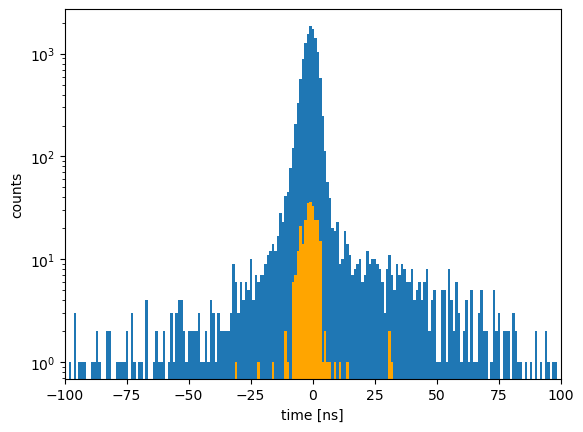

In [505]:

good_t_arr=[]
time_diff=[]
back_to_back_times=[] #inserirò i tempi degli eventi back to back
treshold=-0.018 #soglia fissa
btb_pairs=[np.array([4,5]), np.array([6, 7]), np.array([8, 9]), np.array([10,11]), np.array([12, 13]), np.array([14, 15])]

badev=0
arr_times_all=times_from_waveforms(true_waveforms,20, treshold)
print(arr_times_all)

for ev in range(Nev):
    #trovo il leading edge del gamma da 1200
    index_1200=true_charges[ev].index(max(true_charges[ev]))
    ch_1200=true_channels[ev][index_1200] #trova il canale che ha visto la carica più alta
    t_arr=arr_times_all[ev] #calcolo tempi di arrivo dei segnali
    #ev_is_good=[(t_arr[i] >= t_arr[index_1200] and t_arr[index_1200]!=0) for i in range(len(true_channels[ev]))]

    #if(all(ev_is_good)):

    good_t_arr.append(t_arr)
    t_diff=[t_arr[i] - t_arr[index_1200] for i in range(len(t_arr))]
    #add offset
    t_diff = [t_diff[i] - matrix_loaded[true_channels[ev][i]][true_channels[ev][index_1200]] for i in range(len(t_diff))]
    t_diff.pop(index_1200)
    if(np.mean(np.array(t_diff)) <0): badev+=1
    time_diff.append(t_diff)
     # print(true_channels[ev])
    gamma_channels = [ch for i, ch in enumerate(true_channels[ev]) if i != index_1200] #canali che hanno visto i fotoncini di annichilazione
    #print(gamma_channels)
    for pair in btb_pairs:
        if np.array_equal(sorted(gamma_channels), sorted(pair)):
            back_to_back_times.append(t_diff)
            break  # Exit loop if a match is found

    
        

#print(time_diff)
mean_time_diff=[np.mean(np.array(times)) for times in time_diff if -200< np.mean(np.array(times)) <200]
mean_time_diff=np.array(mean_time_diff)

btb_mean_time_diff =[np.mean(np.array(times)) for times in back_to_back_times]
btb_mean_time_diff = np.array(btb_mean_time_diff)

bins_array = np.arange(np.min(mean_time_diff), np.max(mean_time_diff), step=1) # uncomment to go back to even bins

outofwindow=np.where(mean_time_diff > 0.468*1024)[0]
print(outofwindow)

bin_T, edgesT, _=plt.hist(mean_time_diff, bins=bins_array)
_=plt.hist(btb_mean_time_diff, bins=bins_array, color='orange')
plt.yscale('log')

#pop away the first bin
#bin_T=bin_T[1:-1]
#edgesT=edgesT[1:-1]  #l'ultimo bin eccede la finestra di wavecatcher


#Nbins = len(np.arange(np.min(mean_time_diff), np.max(mean_time_diff), step=4))
Nbin=len(bin_T)


centersT = np.convolve(edgesT, [0.5, 0.5], "valid")
#plt.yscale('log')
plt.xlim(-100, 100)
plt.xlabel('time [ns]')
plt.ylabel('counts')
print(np.min(edgesT))
#evaluate errors

errT = np.sqrt(bin_T)
#print(edgesT)

print(np.min(mean_time_diff))
print("tempi negativi", badev)

In [506]:
#proviamo a fittare
import lmfit
from lmfit import minimize, Parameters, Model
from lmfit.models import GaussianModel, ExponentialModel, ConstantModel, LorentzianModel
                         #ThermalDistributionModel, StepModel #Modelli vari, l'ultimo è Fermi (o Bose)

In [507]:

# Define the truncated exponential function
def myexp(x, amplitude, decay):
    x = np.asarray(x)  # Ensure x is a NumPy array
    result = np.zeros_like(x)
    mask = x >= 0
    result[mask] = amplitude * np.exp(-x[mask] / decay)
    return result

# Create models
exp1 = Model(myexp, independent_vars=['x'], prefix='e1_')
exp2 = Model(myexp, independent_vars=['x'], prefix='e2_')
#gauss1 = GaussianModel(prefix='g1_')
gauss1 = LorentzianModel(prefix='g1_')
offset1 = ConstantModel(prefix='c1_')

# Combine models
model = exp1 + exp2 + gauss1 + offset1


# Initialize parameters
params = gauss1.guess(bin_T, x=centersT)
params.update(exp1.make_params(amplitude=1000, decay=1))
params.update(exp2.make_params(amplitude=300, decay=100))
params.update(offset1.make_params(c=4))

# Update parameters
params["e1_amplitude"].min = 0
params["e2_amplitude"].min = 0
#params["g1_center"].vary = False
params["e2_decay"].set(value=142)

# Ensure all parameters are properly initialized
#params["e1_amplitude"].set(value=1000, min=0)
#params["e1_decay"].set(value=1, min=0)
#params["e2_amplitude"].set(value=10, min=0)
#params["e2_decay"].set(value=142, min=0)
params["g1_amplitude"].set(value=13000, min=0)
#params["g1_center"].set(value=0)
params["g1_sigma"].set(value=3)

result = model.fit(bin_T, params, x=centersT, weights=1 / errT, nan_policy='omit')

# Print fit report
print(result.fit_report())



[[Model]]
    (((Model(myexp, prefix='e1_') + Model(myexp, prefix='e2_')) + Model(lorentzian, prefix='g1_')) + Model(constant, prefix='c1_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 754
    # data points      = 248
    # variables        = 8
    chi-square         = 1182.39844
    reduced chi-square = 4.92666016
    Akaike info crit   = 403.344128
    Bayesian info crit = 431.451558
    R-squared          = 0.99992072
[[Variables]]
    g1_amplitude:  8676.42799 +/- 279.673876 (3.22%) (init = 13000)
    g1_center:    -1.89981605 +/- 0.07070736 (3.72%) (init = -0.3978953)
    g1_sigma:      1.48756588 +/- 0.05976232 (4.02%) (init = 3)
    g1_fwhm:       2.97513175 +/- 0.11952463 (4.02%) == '2.0000000*g1_sigma'
    g1_height:     1856.58529 +/- 74.7598166 (4.03%) == '0.3183099*g1_amplitude/max(1e-15, g1_sigma)'
    e1_amplitude:  1510.64282 +/- 99.2917432 (6.57%) (init = 1000)
    e1_decay:      1.66537420 +/- 0.09683681 (5.81%) (init = 1)
    e2_ampli

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


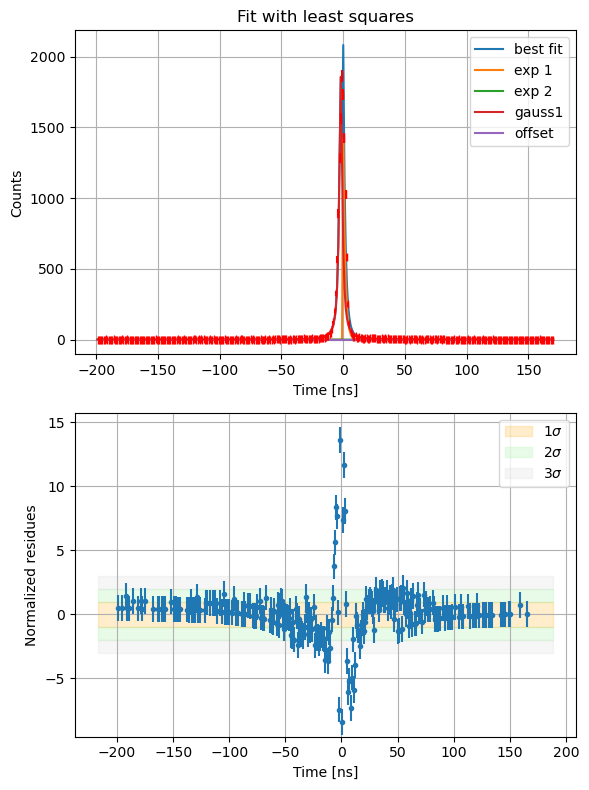

In [508]:
#plot del fit

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

#_ = ax1.hist(mean_time_diff, bins = Nbins, range = [0, 200], color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Time [ns]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(centersT, result.best_fit, label='best fit')
ax1.plot(centersT, comps['e1_'], label='exp 1')
ax1.plot(centersT, comps['e2_'], label='exp 2')
ax1.plot(centersT, comps['g1_'], label='gauss1')
ax1.plot(centersT, comps['c1_'], label='offset')


ax1.legend()
ax1.errorbar(centersT, bin_T, errT, color = "red", fmt='|')
#ax1.set_xlim(10, 100)
ax1.grid()

residueT = bin_T - result.best_fit
norm_resT = residueT / errT

ax2.errorbar(centersT, norm_resT, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Time [ns]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)
#ax1.set_yscale('log')
ax2.legend()
#ax1.set_ylim(0, 100)
ax1.set_title('Fit with least squares')
fig.tight_layout()
plt.show()

In [509]:
emcee_kws = dict(steps=10000, burn=500, thin=20, is_weighted=False,
                 progress=False)
emcee_params = result.params.copy()
emcee_params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2.0))

result_emcee = model.fit(data=bin_T, x=centersT, params=emcee_params, method='emcee',
                         nan_policy='omit', fit_kws=emcee_kws)

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [142.61248381  77.58826412 100.26149441 132.55034487  31.9645105
 372.87341047  46.69069977 426.63582636  62.31097664]


In [510]:
print(result_emcee.fit_report())

[[Model]]
    (((Model(myexp, prefix='e1_') + Model(myexp, prefix='e2_')) + Model(lorentzian, prefix='g1_')) + Model(constant, prefix='c1_'))
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 1000000
    # data points      = 370
    # variables        = 9
    chi-square         = 71338.6336
    reduced chi-square = 197.613943
    Akaike info crit   = 1964.82541
    Bayesian info crit = 2000.04694
    R-squared          = 0.99521653
[[Variables]]
    g1_amplitude:  13835.7375 +/- 24.1206606 (0.17%) (init = 8676.428)
    g1_center:    -1.13542542 +/- 0.00495224 (0.44%) (init = -1.899816)
    g1_sigma:      2.39447157 +/- 0.00371056 (0.15%) (init = 1.487566)
    g1_fwhm:       4.78894315 == '2.0000000*g1_sigma'
    g1_height:     1839.25851 == '0.3183099*g1_amplitude/max(1e-15, g1_sigma)'
    e1_amplitude:  451.947574 +/- 4.88110568 (1.08%) (init = 1510.643)
    e1_decay:      2.18170615 +/- 0.01239789 (0.57%) (init = 1.665374)
    e2_amplitude:  0.02155769 +/- 0.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


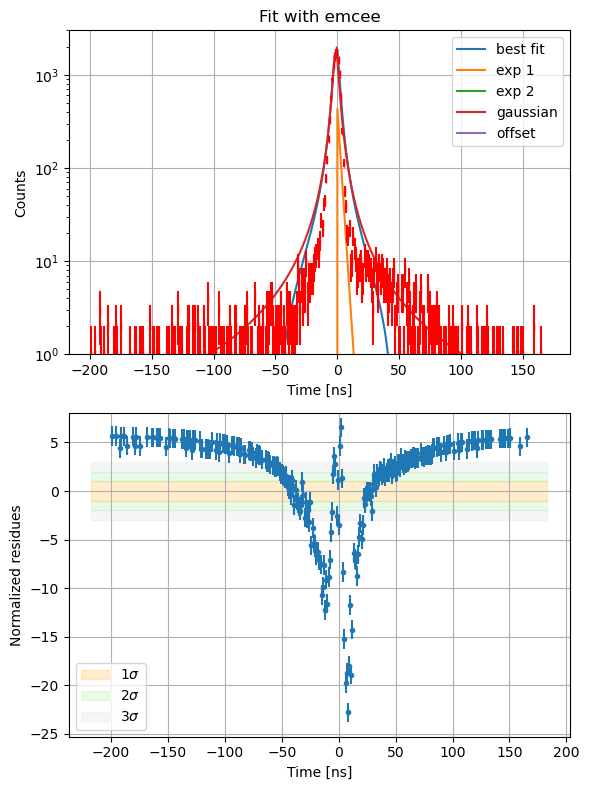

In [511]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

#_ = ax1.hist(mean_time_diff, bins = Nbins, range = [0, 200], color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Time [ns]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result_emcee.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(centersT, result_emcee.best_fit, label='best fit')
ax1.plot(centersT, comps['e1_'], label='exp 1')
ax1.plot(centersT, comps['e2_'], label='exp 2')
ax1.plot(centersT, comps['g1_'], label='gaussian')
ax1.plot(centersT, comps['c1_'], label='offset')

ax1.legend()
ax1.errorbar(centersT, bin_T, errT, color = "red", fmt='|')
#ax1.set_xlim(0, 200)
ax1.grid()

residueT = bin_T - result_emcee.best_fit
norm_resT = residueT / errT

ax2.errorbar(centersT, norm_resT, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Time [ns]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)
ax1.set_yscale('log')
ax2.legend()
ax1.set_ylim(1, 3000)
ax1.set_title('Fit with emcee')
fig.tight_layout()
plt.show()

-273.732505521646
[[Model]]
    Model(exponential, prefix='e1_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 29
    # variables        = 2
    chi-square         = 270.000000
    reduced chi-square = 10.00000000
    Akaike info crit   = 68.7026577
    Bayesian info crit = 71.4372494
    R-squared          = 0.95684496
##  Warning: uncertainties could not be estimated:
    e1_amplitude:  at initial value
    e1_amplitude:  at boundary
[[Variables]]
    e1_amplitude:  1.7764e-14 (init = 1.768761e-14)
    e1_decay:      3.78685202 (init = 4)
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [300.00118069          nan  68.27651095]


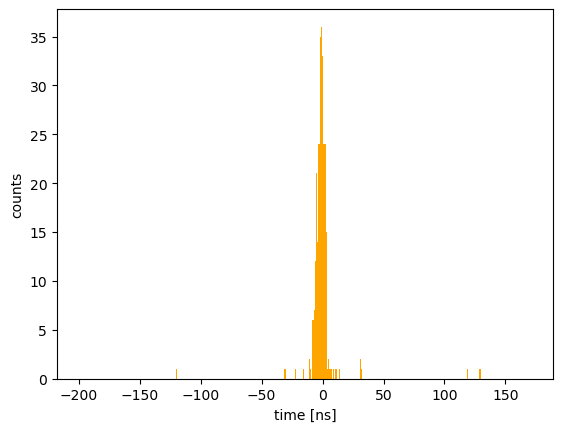

In [512]:
#fitto solo la componente back to back

bin_btb, edges_btb, _=plt.hist(btb_mean_time_diff, bins=bins_array, color='orange')

print(np.min(btb_mean_time_diff))

#bin_btb=bin_btb[1:-1]
#edges_btb=edges_btb[1:-1]  

centers_btb = np.convolve(edges_btb, [0.5, 0.5], "valid")
plt.xlabel('time [ns]')
plt.ylabel('counts')
err_btb = np.sqrt(bin_btb)

exp1   = ExponentialModel(prefix='e1_')

model = exp1 

params = exp1.guess(bin_btb, x=centers_btb)  
params["e1_amplitude"].min = 0
params["e1_decay"].set(value=4)

result = model.fit(bin_btb, params, x = centers_btb, weights = 1 / err_btb,nan_policy='omit')

print(result.fit_report())

emcee_kws = dict(steps=5000, burn=500, thin=20, is_weighted=False,
                 progress=False)
emcee_params = result.params.copy()
emcee_params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2.0))

result_emcee_btb = model.fit(data=bin_btb, x=centers_btb, params=emcee_params, method='emcee',
                         nan_policy='omit', fit_kws=emcee_kws)

In [513]:
print(result_emcee_btb.fit_report())

[[Model]]
    Model(exponential, prefix='e1_')
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 500000
    # data points      = 370
    # variables        = 3
    chi-square         = 1566.10750
    reduced chi-square = 4.26732289
    Akaike info crit   = 539.852841
    Bayesian info crit = 551.593350
    R-squared          = 0.74968356
[[Variables]]
    e1_amplitude:  0.73029565 +/- 0.12528180 (17.15%) (init = 1.776357e-14)
    e1_decay:      3.6784e+19 +/- 5.628e+152 (1529932339927880148830989039361839571394130930476788694899301410503606344748603483187983138257454736582667844525937661109627580581937152.00%) (init = 3.786852)
    __lnsigma:     0.69251484 +/- 9.4056e-04 (0.14%) (init = -2.302585)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


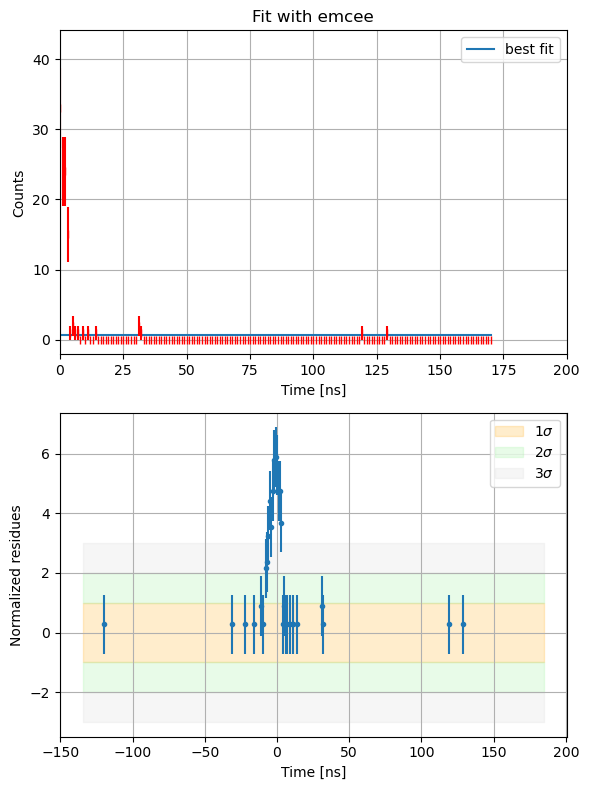

In [514]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

#_ = ax1.hist(mean_time_diff, bins = Nbins, range = [0, 200], color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Time [ns]')
ax1.set_ylabel('Counts')
ax1.legend()

#comps = result_emcee.eval_components()                       
ax1.plot(centers_btb, result_emcee_btb.best_fit, label='best fit')


ax1.legend()
ax1.errorbar(centers_btb, bin_btb, err_btb, color = "red", fmt='|')
ax1.set_xlim(0, 200)
ax1.grid()

residue_btb = bin_btb - result_emcee_btb.best_fit
norm_res_btb = residue_btb / err_btb

ax2.errorbar(centers_btb, norm_res_btb, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Time [ns]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)
#ax1.set_yscale('log')
ax2.legend()
#ax1.set_ylim(1, 1000)
ax1.set_title('Fit with emcee')
fig.tight_layout()

[1.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 2.000e+00 1.000e+00 0.000e+00 0.000e+00
 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 2.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 2.000e+00
 1.000e+00 1.000e+00 1.000e+00 0.000e+00 3.000e+00 1.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 2.000e+00 1.000e+00
 0.000e+00 0.000e+00 2.000e+00 0.000e+00 2.000e+00 0.000e+00 2.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 2.000e+00 1.000e+00 0.000e+00
 4.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000

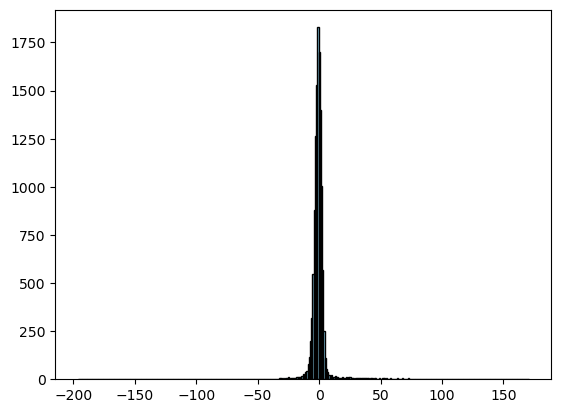

In [515]:
#isolo la componente a 3 fotoni

three_gamma_ortho=bin_T - bin_btb
three_gamma_edges=edgesT

three_gamma_ortho = three_gamma_ortho[3:]
three_gamma_edges = three_gamma_edges[3:]

print(three_gamma_ortho, three_gamma_edges)
three_gamma_centers = np.convolve(three_gamma_edges, [0.5, 0.5], "valid")
three_g_err=np.sqrt(three_gamma_ortho)
plt.bar(three_gamma_edges[:-1], three_gamma_ortho, width=(three_gamma_edges[1] - three_gamma_edges[0]),align='edge', color='skyblue', edgecolor='black')

exp1   = ExponentialModel(prefix='e1_')

model = exp1 

params = exp1.guess(three_gamma_ortho, x=three_gamma_centers)  
params["e1_amplitude"].min = 0

result = model.fit(three_gamma_ortho, params, x = three_gamma_centers, weights = 1 / three_g_err,nan_policy='omit')

print(result.fit_report())

emcee_kws = dict(steps=5000, burn=500, thin=20, is_weighted=False,
                 progress=False)
emcee_params = result.params.copy()
emcee_params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2.0))

result_emcee_3g = model.fit(data=three_gamma_ortho, x=three_gamma_centers, params=emcee_params, method='emcee',
                         nan_policy='omit', fit_kws=emcee_kws)


In [516]:
print(result_emcee_3g.fit_report())

[[Model]]
    Model(exponential, prefix='e1_')
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 500000
    # data points      = 367
    # variables        = 3
    chi-square         = 3579501.12
    reduced chi-square = 9833.79427
    Akaike info crit   = 3377.03158
    Bayesian info crit = 3388.74766
    R-squared          = 0.74999989
[[Variables]]
    e1_amplitude:  34.8862353 +/- 0.12621774 (0.36%) (init = 1.869999)
    e1_decay:      1.6666e+25 +/- 3.133e+157 (188013390529010980212783276367676596003853932970661796356469813982332525871744509644342012319122475953888438676286970977817745042702336.00%) (init = 5.673667e+08)
    __lnsigma:     0.69314697 +/- 3.1079e-07 (0.00%) (init = -2.302585)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


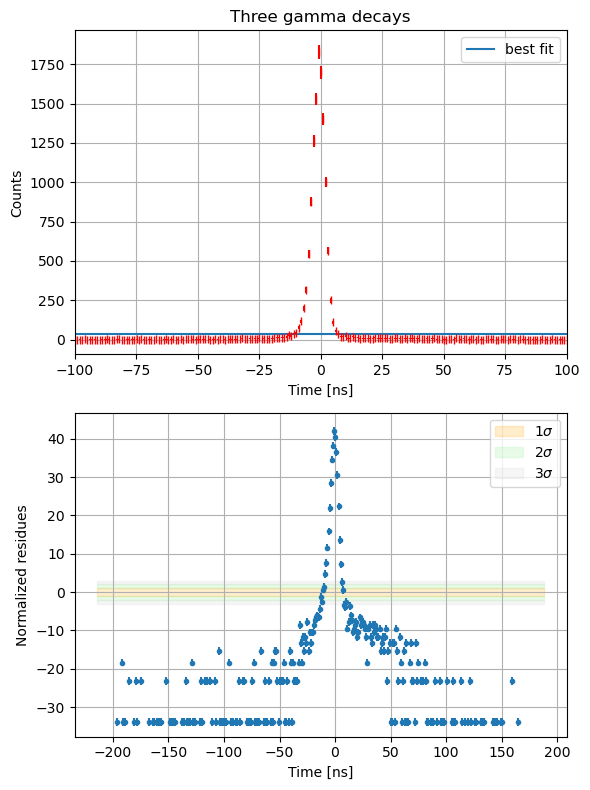

In [517]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

#_ = ax1.hist(mean_time_diff, bins = Nbins, range = [0, 200], color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Time [ns]')
ax1.set_ylabel('Counts')
ax1.legend()

#comps = result_emcee.eval_components()                       
ax1.plot(three_gamma_centers, result_emcee_3g.best_fit, label='best fit')


ax1.legend()
ax1.errorbar(three_gamma_centers, three_gamma_ortho, three_g_err, color = "red", fmt='|')
ax1.set_xlim(-100, 100)
ax1.grid()

residue_3g = three_gamma_ortho - result_emcee_3g.best_fit
norm_res_3g = residue_3g / three_g_err

ax2.errorbar(three_gamma_centers, norm_res_3g, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Time [ns]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)
#ax1.set_yscale('log')
ax2.legend()
ax1.set_title('Three gamma decays')
fig.tight_layout()

# Un po' di speculazioni da strutturista secondo il modello di Tao-Eldrup

In [518]:
delta = 0.166 #nm
lambdabar = 2.01 #ns^-1
lambda_po= 1/result_emcee_btb.params["e1_decay"].value #ns^-1
tau_po = result_emcee_btb.params["e1_decay"].value #ns
Rc = (tau_po + 5.07)/1.88
print(Rc)

1.956587443287359e+19


Original number of bins: 300
Symmetrized number of bins: 150
Filtered number of edges: 151
Final number of bins: 150
Final number of edges: 151


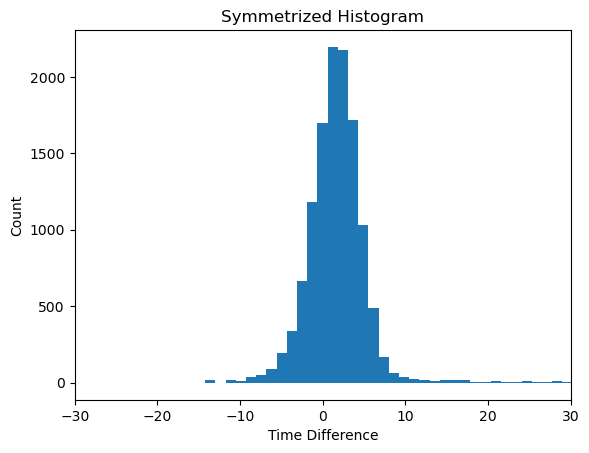

In [519]:

mean_time_diff = np.array([tdiff for tdiff in mean_time_diff if -300 < tdiff < 300])

# Compute the histogram with 300 bins
bin_T_new, edgesT_new, _ = plt.hist(mean_time_diff, bins=300)
plt.close()  # Close the plot to avoid displaying it

print(f'Original number of bins: {len(bin_T_new)}')

# Initialize the symmetrized bin list
bin_T_new_symmetrized = []

# Calculate the symmetrized bin counts by summing symmetric bins around the center
# Leaving the central bin unaltered
central_bin_index = 149
bin_T_new_symmetrized.append(bin_T_new[central_bin_index])
for i in range(central_bin_index):
    sym_value = (bin_T_new[central_bin_index + i] - bin_T_new[central_bin_index - i]) 
    bin_T_new_symmetrized.append(sym_value)  

print(f'Symmetrized number of bins: {len(bin_T_new_symmetrized)}')

# Filter the edges to keep only those that are non-negative
edgesT_new_filtered = edgesT_new[central_bin_index+1:]

print(f'Filtered number of edges: {len(edgesT_new_filtered)}')

print(f'Final number of bins: {len(bin_T_new_symmetrized)}')
print(f'Final number of edges: {len(edgesT_new_filtered)}')

# Plot the histogram using plt.bar
plt.bar(edgesT_new_filtered[:-1], bin_T_new_symmetrized, width=edgesT_new_filtered[1]-edgesT_new_filtered[0], align='edge')
plt.xlim(-30,30)
plt.xlabel('Time Difference')
plt.ylabel('Count')
plt.title('Symmetrized Histogram')
plt.show()

